In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr

In [169]:
data = pd.read_csv("LoanData.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (34,37,38,67,80,82,83,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


-0.07280563918543621


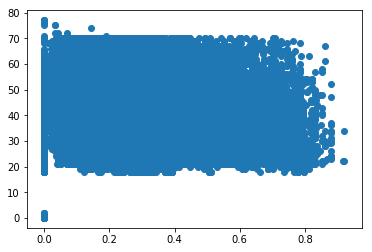

In [42]:
#Task1
#Calculate Spearman correlation coefficient
print(data.ProbabilityOfDefault.fillna(0).corr(data.Age.fillna(0), "spearman"))
#Plot dependencies
plt.scatter(data.ProbabilityOfDefault.fillna(0), data.Age.fillna(0))

In [43]:
#Task2
#Groupby country and raitin, find the number of each
data[data.NewCreditCustomer == True].groupby(['Country','Rating']).Rating.count()



Country  Rating
EE       A          688
         AA         121
         B         2288
         C         5631
         D         7286
         E         7627
         F         1342
         HR        1165
ES       B           11
         C           45
         D          844
         E         1165
         F         3612
         HR        7032
FI       A           52
         AA          57
         B          448
         C          957
         D         2487
         E         2512
         F         9504
         HR        2456
SK       D            6
         E           11
         F           58
         HR         214
Name: Rating, dtype: int64

In [134]:
#Task3
#Country, Education, MaturityDate and NewCreditCustomer
#Import library
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import numpy as np
countries = list(data.Country.unique())

#Labels
train_y = data.DefaultDate.fillna(0).apply(lambda x: 1 if x!=0 else 0)
#Select needed features
train_X = data[['Country', 'Education', 'MaturityDate_Original',  'NewCreditCustomer']].fillna(0)
#Change format to float as being on maturity leave or not
train_X['MaturityDate_Original'] = data.MaturityDate_Original.apply(lambda x: 1 if x!=0 else 0)
#Encode feature to integer
train_X['Country'] = data.Country.apply(lambda x: countries.index(x))
#Change format from boolean to int
train_X['NewCreditCustomer'] = data.NewCreditCustomer.apply(lambda x: 1 if x==True else 0 )
#Train logistic regression
lr = sm.Logit(train_y, train_X)
#Fit to the model
logit = lr.fit()
#Print summary of the training
print(logit.summary2())

Optimization terminated successfully.
         Current function value: 0.608719
         Iterations 5
                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.036      
Dependent Variable:   DefaultDate       AIC:               127946.0758
Date:                 2019-09-02 11:37  BIC:               127984.3260
No. Observations:     105088            Log-Likelihood:    -63969.    
Df Model:             3                 LL-Null:           -66334.    
Df Residuals:         105084            LLR p-value:       0.0000     
Converged:            1.0000            Scale:             1.0000     
No. Iterations:       5.0000                                          
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Country                0.4186   0.0080  52.3171 0.0000  0.4029  0.4343
Edu

We can see that all features have p-value equal to 0. Which means that all features are highly significant in default exsistence prediction.

In [226]:
#Task4
#Groupping by the given features and calculating mean and count per each segment
data_gr = data.groupby(['Country', 'Education', 'NewCreditCustomer']).ProbabilityOfDefault.aggregate(['mean', 'count']).reset_index()
#Filtring based segments more than 1000 observations
data_gr = data_gr[data_gr['count']>1000]
#Finding the segment with the lowest default rate
dg = data_gr[data_gr['mean']==data_gr['mean'].min()]
print(dg)

print("Segment size is : {}".format(dg['count']))

   Country  Education  NewCreditCustomer      mean  count
12      EE        5.0              False  0.147355   8079
Segment size is : 12    8079
Name: count, dtype: int64


In [209]:
#Task5
#Import libraries
import numpy as np

#Filter dates
data_def = data[(data.FirstPaymentDate > '2016-01-01') & (data.FirstPaymentDate < '2017-11-01')][['ProbabilityOfDefault','DefaultDate', 'Country']]

#Predictions with a probability higher and equal than 0.5 will be considered as 1 others as 0
data_def.ProbabilityOfDefault = data.ProbabilityOfDefault.apply(lambda x : 1 if x>=0.5 else 0)

#Accuracy - as filtered data contains only payments (non started payments excluded), 
# we calculate number of predicted payments to be started, then devided by all produced payments
print("Accuracy:")
print( np.sum(data_def.ProbabilityOfDefault)/len(data_def))

#Accuracy for each countries
d = data_def.groupby('Country').ProbabilityOfDefault.aggregate(['sum','count']).reset_index()
d['accuracy'] = d['sum']/d['count']
print(d)

Accuracy:
0.17422739496539258
  Country   sum  count  accuracy
0      EE   112  13456  0.008323
1      ES  3481   5730  0.607504
2      FI   359   3497  0.102659


We can see that the model is not well calibrated, as accuracy is too low. For Estonia it is calibrated well.